### Regression

                  date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07 00:00:00   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08 00:00:00   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11 00:00:00   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volu

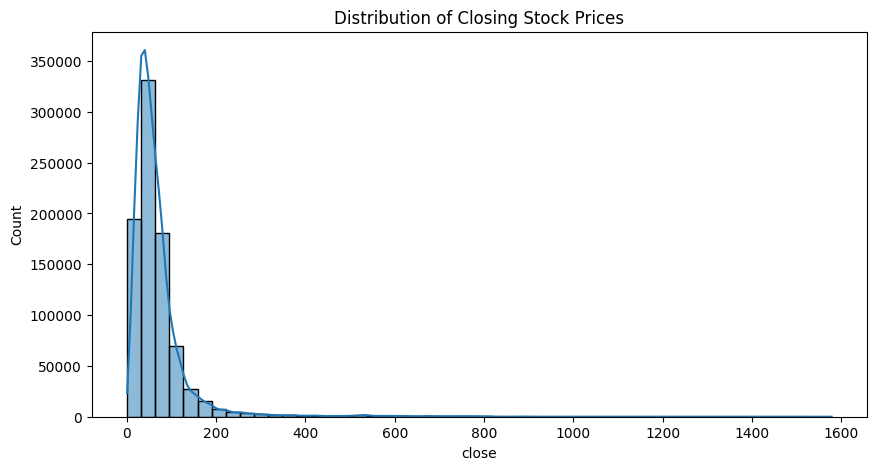

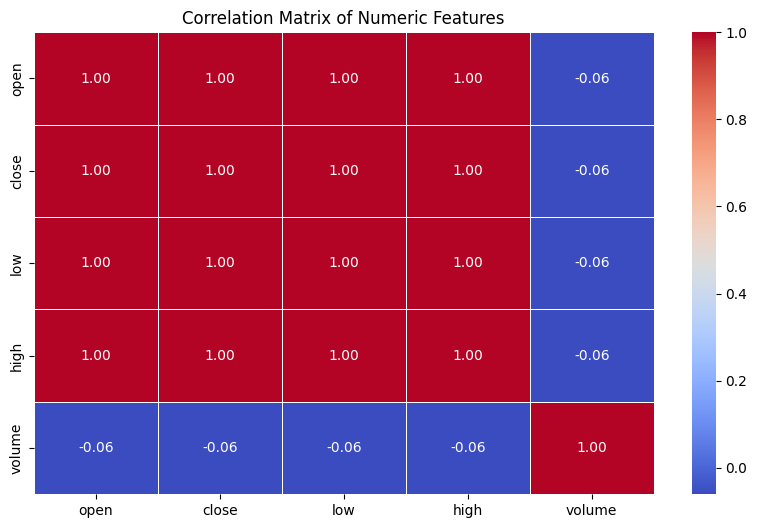

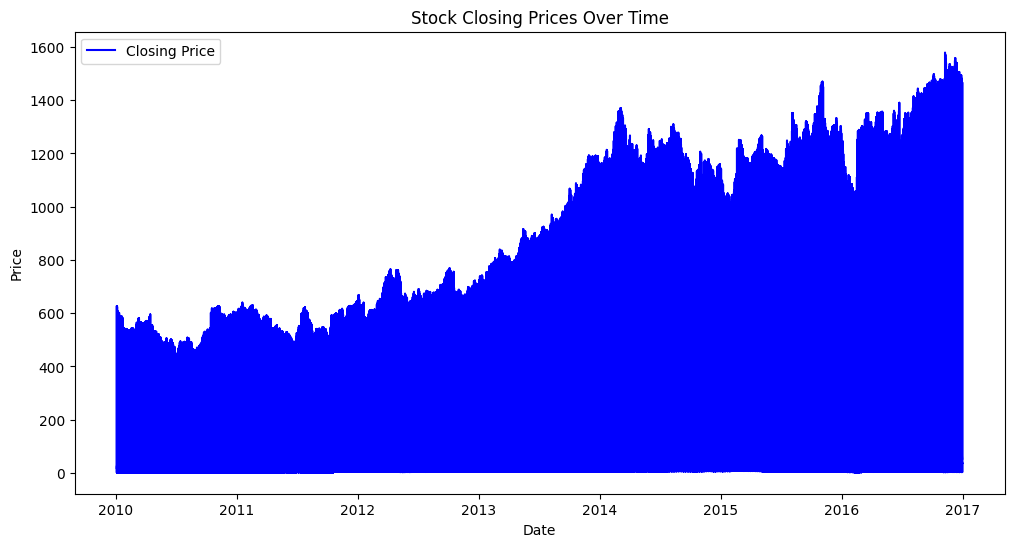

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('data/prices.csv')

# Display dataset information
print(df.head())
print(df.info())
print(df.isnull().sum())
print(df.describe())

# Plot distribution of closing prices
plt.figure(figsize=(10,5))
sns.histplot(df['close'], bins=50, kde=True)
plt.title("Distribution of Closing Stock Prices")
plt.show()

# Convert date column to datetime
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], format='mixed', errors='coerce')
    df = df.sort_values(by="date")

# Compute correlation matrix
corr = df.select_dtypes(include=['number']).corr()

# Plot correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Plot closing prices over time
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['close'], label="Closing Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Closing Prices Over Time")
plt.legend()
plt.show()


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# Preprocess dataset
df = df.drop(columns=['symbol', 'date'])
X = df.drop(columns=['close']).values
y = df['close'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

class StockPriceRegressor(nn.Module):
    def __init__(self, input_size):
        super(StockPriceRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize and configure model
input_size = X_train.shape[1]
model = StockPriceRegressor(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

# Training configuration
epochs = 100
batch_size = 64
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# Evaluate model
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).numpy()
    y_pred_test = model(X_test).numpy()

train_mse = mean_squared_error(y_train.numpy(), y_pred_train)
test_mse = mean_squared_error(y_test.numpy(), y_pred_test)

print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")


torch.Size([681011, 4]) torch.Size([681011, 1]) torch.Size([170253, 4]) torch.Size([170253, 1])
StockPriceRegressor(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
Epoch 10/100, Loss: 68.0479
Epoch 20/100, Loss: 49.4296
Epoch 30/100, Loss: 44.9277
Epoch 40/100, Loss: 40.7838
Epoch 50/100, Loss: 34.0997
Epoch 60/100, Loss: 30.0695
Epoch 70/100, Loss: 26.1420
Epoch 80/100, Loss: 26.8033
Epoch 90/100, Loss: 27.3073
Epoch 100/100, Loss: 25.8264
Train MSE: 217473.5000
Test MSE: 217524.7500


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from itertools import product
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class StockPriceRegressor(nn.Module):
    def __init__(self, input_size, layer_sizes, dropout_rate):
        super(StockPriceRegressor, self).__init__()
        layers = []
        prev_size = input_size

        for size in layer_sizes:
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = size

        layers.append(nn.Linear(prev_size, 1)) 
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

learning_rates = [0.01]
optimizers = [optim.Adam]
layer_sizes_list = [(128, 64)]  
batch_sizes = [32]  
dropout_rates = [0.3]

best_mse = float("inf")
best_params = None

X_train_tensor = X_train.to(device).float()
y_train_tensor = y_train.to(device).float().unsqueeze(1).squeeze()
X_test_tensor = X_test.to(device).float()
y_test_tensor = y_test.to(device).float().unsqueeze(1).squeeze()

start_time = time.time()

for lr, opt_func, layer_sizes, batch_size, dropout_rate in product(learning_rates, optimizers, layer_sizes_list, batch_sizes, dropout_rates):

    print(f"\n🔍 Testing: LR={lr}, Optimizer={opt_func.__name__}, Layers={layer_sizes}, Batch={batch_size}, Dropout={dropout_rate}")

    model = StockPriceRegressor(input_size=X_train_tensor.shape[1], layer_sizes=layer_sizes, dropout_rate=dropout_rate).to(device)
    optimizer = opt_func(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    epochs = 3
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor).cpu().numpy()
        y_pred_test_squeezed = np.squeeze(y_pred_test)

    if np.isnan(y_pred_test_squeezed).any():
        continue

    try:
        y_test_squeezed = np.squeeze(y_test_tensor.cpu().numpy())
        test_mse = mean_squared_error(y_test_squeezed, y_pred_test_squeezed)
    except ValueError as e:
        continue

    if test_mse < best_mse:
        best_mse = test_mse
        best_params = (lr, opt_func, layer_sizes, batch_size, dropout_rate)

end_time = time.time()

print(f"Best Params: LR={best_params[0]}, Opt={best_params[1].__name__}, Layers={best_params[2]}, Batch={best_params[3]}, Dropout={best_params[4]}")
print(f"Best Test MSE: {best_mse:.4f}")
print(f"Time Taken: {end_time - start_time:.2f} sec")



🔍 Testing: LR=0.01, Optimizer=Adam, Layers=(128, 64), Batch=32, Dropout=0.3


c:\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


🧪 Test MSE: 6690.8208

✅ Best Hyperparameters:
   - Learning Rate: 0.01
   - Optimizer: Adam
   - Layers: (128, 64)
   - Batch Size: 32
   - Dropout Rate: 0.3
✅ Best Test MSE: 6690.8208

⏳ Total time taken: 93.98 seconds


c:\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.red

Epoch 1/10, Train Loss: 7088.9635, Test Loss: 7141.7713
Epoch 2/10, Train Loss: 7040.1894, Test Loss: 7143.0756
Epoch 3/10, Train Loss: 7034.8251, Test Loss: 7142.4044
Epoch 4/10, Train Loss: 7027.2952, Test Loss: 7147.6914
Epoch 5/10, Train Loss: 7023.1456, Test Loss: 7142.4145
Epoch 6/10, Train Loss: 7017.1021, Test Loss: 7141.2091
Epoch 7/10, Train Loss: 7012.8805, Test Loss: 7141.0557
Epoch 8/10, Train Loss: 7009.2308, Test Loss: 7144.0546
Epoch 9/10, Train Loss: 7005.9564, Test Loss: 7140.9217
Epoch 10/10, Train Loss: 7002.4681, Test Loss: 7141.7370


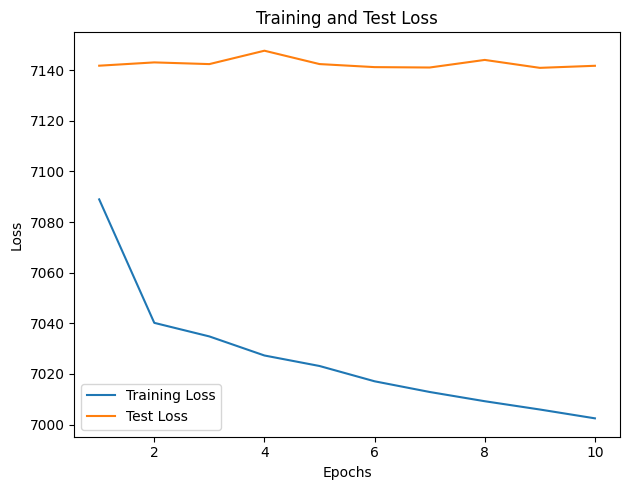

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

class StockPriceRegressor(nn.Module):
    def __init__(self, input_size, layer_sizes=(64, 32), dropout_rate=0.2):
        super(StockPriceRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, layer_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(layer_sizes[0], layer_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(layer_sizes[1], 1)  # Output layer for regression
        )

    def forward(self, x):
        return self.layers(x)

batch_size = 32  
learning_rate = 0.001 
epochs = 10  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = X_train_tensor.cpu()
y_train_tensor = y_train_tensor.cpu()
X_test_tensor = X_test_tensor.cpu()
y_test_tensor = y_test_tensor.cpu()

model = StockPriceRegressor(input_size=X_train_tensor.shape[1], layer_sizes=(64, 32), dropout_rate=0.2).to(device) 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  

train_losses = []
test_losses = []


for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_epoch_loss = 0.0
    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch = X_test_batch.to(device)
            y_test_batch = y_test_batch.to(device)

            y_pred_test_batch = model(X_test_batch)
            test_loss = criterion(y_pred_test_batch, y_test_batch).item()
            test_epoch_loss += test_loss * X_test_batch.size(0)  

            del X_test_batch, y_test_batch, y_pred_test_batch, test_loss
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        test_loss = test_epoch_loss / len(test_loader.dataset)
        test_losses.append(test_loss)


    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    del X_batch, y_batch, y_pred, loss
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

epochs_range = range(1, epochs + 1)  

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.tight_layout()
plt.show()

Training Original Model (No Regularization)


c:\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([51])) that is different to the input size (torch.Size([51, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.r

Epoch 1/10, Train Loss: 7126.0602, Test Loss: 7147.8628
Epoch 2/10, Train Loss: 7045.8868, Test Loss: 7149.9742
Epoch 3/10, Train Loss: 7039.4262, Test Loss: 7153.1272
Epoch 4/10, Train Loss: 7033.5178, Test Loss: 7147.3336
Epoch 5/10, Train Loss: 7027.2594, Test Loss: 7148.0249
Epoch 6/10, Train Loss: 7022.8608, Test Loss: 7148.9405
Epoch 7/10, Train Loss: 7017.1356, Test Loss: 7147.6355
Epoch 8/10, Train Loss: 7013.8385, Test Loss: 7147.5301
Epoch 9/10, Train Loss: 7009.1224, Test Loss: 7152.8654
Epoch 10/10, Train Loss: 7005.7595, Test Loss: 7149.1094

Training L1 Regularized Model
Epoch 1/10, Train Loss: 7101.9754, Test Loss: 7147.7745
Epoch 2/10, Train Loss: 7029.3246, Test Loss: 7153.4835
Epoch 3/10, Train Loss: 7024.6423, Test Loss: 7160.5215
Epoch 4/10, Train Loss: 7019.4413, Test Loss: 7159.1334
Epoch 5/10, Train Loss: 7015.0165, Test Loss: 7148.4411
Epoch 6/10, Train Loss: 7009.1303, Test Loss: 7147.6077
Epoch 7/10, Train Loss: 7002.2879, Test Loss: 7147.4952
Epoch 8/10, Trai

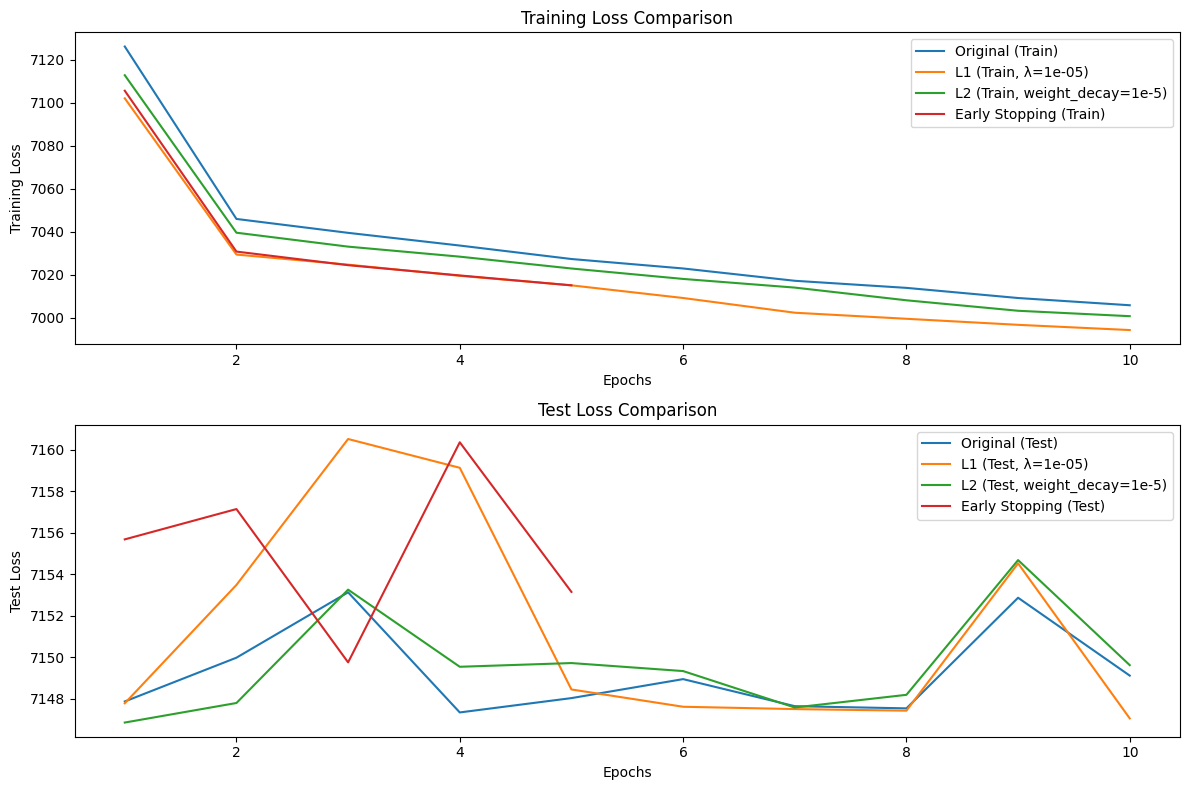


--- Comparison and Interpretation ---
Original Model - Final Test Loss: 7149.1094
L1 Regularized Model - Final Test Loss: 7147.0455
L2 Regularized Model - Final Test Loss: 7149.6143
Early Stopping Model - Final Test Loss: 7153.1459

Interpretations:
- L1 regularization can lead to sparsity (some weights become zero), which can simplify the model.
- L2 regularization penalizes large weights, promoting a smoother model and preventing overfitting.
- Early stopping prevents overfitting by stopping training when the performance on the validation set starts to degrade.
- Compare the training and test loss curves.  A large gap between training and test loss suggests overfitting.
- Regularization techniques are most effective when overfitting is a problem.


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

class StockPriceRegressor(nn.Module):
    def __init__(self, input_size, layer_sizes=(32, 16), dropout_rate=0.1):  
        super(StockPriceRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, layer_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(layer_sizes[0], layer_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(layer_sizes[1], 1)  
        )

    def forward(self, x):
        return self.layers(x)


batch_size = 64 
learning_rate = 0.002
epochs = 10  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = X_train_tensor.cpu()
y_train_tensor = y_train_tensor.cpu()
X_test_tensor = X_test_tensor.cpu()
y_test_tensor = y_test_tensor.cpu()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)  
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=4, pin_memory=True)  

def train_model(model, optimizer, criterion, train_loader, test_loader, epochs, device, l1_lambda=0.0, early_stopping_patience=None):
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device, non_blocking=True) 
            y_batch = y_batch.to(device, non_blocking=True)  

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        test_epoch_loss = 0.0
        with torch.no_grad():
            for X_test_batch, y_test_batch in test_loader:
                X_test_batch = X_test_batch.to(device, non_blocking=True)
                y_test_batch = y_test_batch.to(device, non_blocking=True) 

                y_pred_test_batch = model(X_test_batch)
                test_loss = criterion(y_pred_test_batch, y_test_batch).item()
                test_epoch_loss += test_loss * X_test_batch.size(0)

                del X_test_batch, y_test_batch, y_pred_test_batch
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        test_loss = test_epoch_loss / len(test_loader.dataset)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        if early_stopping_patience is not None:
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model_state = model.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve == early_stopping_patience:
                    print("Stopping triggered!")
                    model.load_state_dict(best_model_state)
                    break
        else:
            best_model_state = model.state_dict()

        del X_batch, y_batch, y_pred, loss
        if torch.cuda.is_available():
          torch.cuda.empty_cache()

    return train_losses, test_losses, model


print("Training Original Model (No Regularization)")
model_original = StockPriceRegressor(input_size=X_train_tensor.shape[1], layer_sizes=(32, 16), dropout_rate=0.1).to(device)
optimizer_original = optim.Adam(model_original.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
train_losses_original, test_losses_original, model_original = train_model(model_original, optimizer_original, criterion, train_loader, test_loader, epochs, device)


print("\nTraining L1 Regularized Model")
l1_lambda = 1e-5
model_l1 = StockPriceRegressor(input_size=X_train_tensor.shape[1], layer_sizes=(32, 16), dropout_rate=0.1).to(device)
optimizer_l1 = optim.Adam(model_l1.parameters(), lr=learning_rate)
train_losses_l1, test_losses_l1, model_l1 = train_model(model_l1, optimizer_l1, criterion, train_loader, test_loader, epochs, device, l1_lambda=l1_lambda)

print("\nTraining L2 Regularized Model")
model_l2 = StockPriceRegressor(input_size=X_train_tensor.shape[1], layer_sizes=(32, 16), dropout_rate=0.1).to(device)
optimizer_l2 = optim.Adam(model_l2.parameters(), lr=learning_rate, weight_decay=1e-5)
train_losses_l2, test_losses_l2, model_l2 = train_model(model_l2, optimizer_l2, criterion, train_loader, test_loader, epochs, device)

print("\nTraining Early Stopping Model")
early_stopping_patience = 2 
model_es = StockPriceRegressor(input_size=X_train_tensor.shape[1], layer_sizes=(32, 16), dropout_rate=0.1).to(device)
optimizer_es = optim.Adam(model_es.parameters(), lr=learning_rate)
train_losses_es, test_losses_es, model_es = train_model(model_es, optimizer_es, criterion, train_loader, test_loader, epochs, device, early_stopping_patience=early_stopping_patience)

epochs_range = range(1, len(train_losses_original) + 1) 

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(epochs_range[:len(train_losses_original)], train_losses_original, label='Original (Train)')
plt.plot(epochs_range[:len(train_losses_l1)], train_losses_l1, label=f'L1 (Train, λ={l1_lambda})')
plt.plot(epochs_range[:len(train_losses_l2)], train_losses_l2, label='L2 (Train, weight_decay=1e-5)')
plt.plot(epochs_range[:len(train_losses_es)], train_losses_es, label='Early Stopping (Train)')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs_range[:len(test_losses_original)], test_losses_original, label='Original (Test)')
plt.plot(epochs_range[:len(test_losses_l1)], test_losses_l1, label=f'L1 (Test, λ={l1_lambda})')
plt.plot(epochs_range[:len(test_losses_l2)], test_losses_l2, label='L2 (Test, weight_decay=1e-5)')
plt.plot(epochs_range[:len(test_losses_es)], test_losses_es, label='Early Stopping (Test)')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Test Loss Comparison')
plt.legend()


plt.tight_layout()
plt.show()

print("\n--- Comparison and Interpretation ---")
print(f"Original Model - Final Test Loss: {test_losses_original[-1]:.4f}")
print(f"L1 Regularized Model - Final Test Loss: {test_losses_l1[-1]:.4f}")
print(f"L2 Regularized Model - Final Test Loss: {test_losses_l2[-1]:.4f}")
print(f"Early Stopping Model - Final Test Loss: {test_losses_es[-1]:.4f}")

print("\nInterpretations:")
print("- L1 regularization can lead to sparsity (some weights become zero), which can simplify the model.")
print("- L2 regularization penalizes large weights, promoting a smoother model and preventing overfitting.")
print("- Early stopping prevents overfitting by stopping training when the performance on the validation set starts to degrade.")
print("- Compare the training and test loss curves.  A large gap between training and test loss suggests overfitting.")
print("- Regularization techniques are most effective when overfitting is a problem.")

### Classification

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  
import numpy as np 

data = pd.read_csv("data/predictive_maintenance.csv", encoding='utf-8') 
print(data.head())
print(data.info())

data = data.drop(['UDI'], axis=1) 
data = data.drop(['Product ID'], axis=1)  


numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Type']
target = 'Target' 

print("Columns in the DataFrame:", data.columns)

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  
])

preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features)
], remainder='passthrough')

X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

X_train = preprocessor.fit_transform(X_train) 
X_test = preprocessor.transform(X_test) 
print("Shape of X_train after preprocessing:", X_train.shape)
print("Shape of X_test after preprocessing:", X_test.shape)
print(X_train)
print(X_test)

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (tota

Data shape: (10000, 8)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Type                     10000 non-null  object  
 1   Air temperature [K]      10000 non-null  float64 
 2   Process temperature [K]  10000 non-null  float64 
 3   Rotational speed [rpm]   10000 non-null  int64   
 4   Torque [Nm]              10000 non-null  float64 
 5   Tool wear [min]          10000 non-null  int64   
 6   Target                   10000 non-null  category
 7   Failure Type             10000 non-null  category
dtypes: category(2), float64(3), int64(2), object(1)
memory usage: 488.7+ KB
None

Descriptive Statistics:
       Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count         10000.000000             10000.000000            10000.000000   
mean            300.004930               31

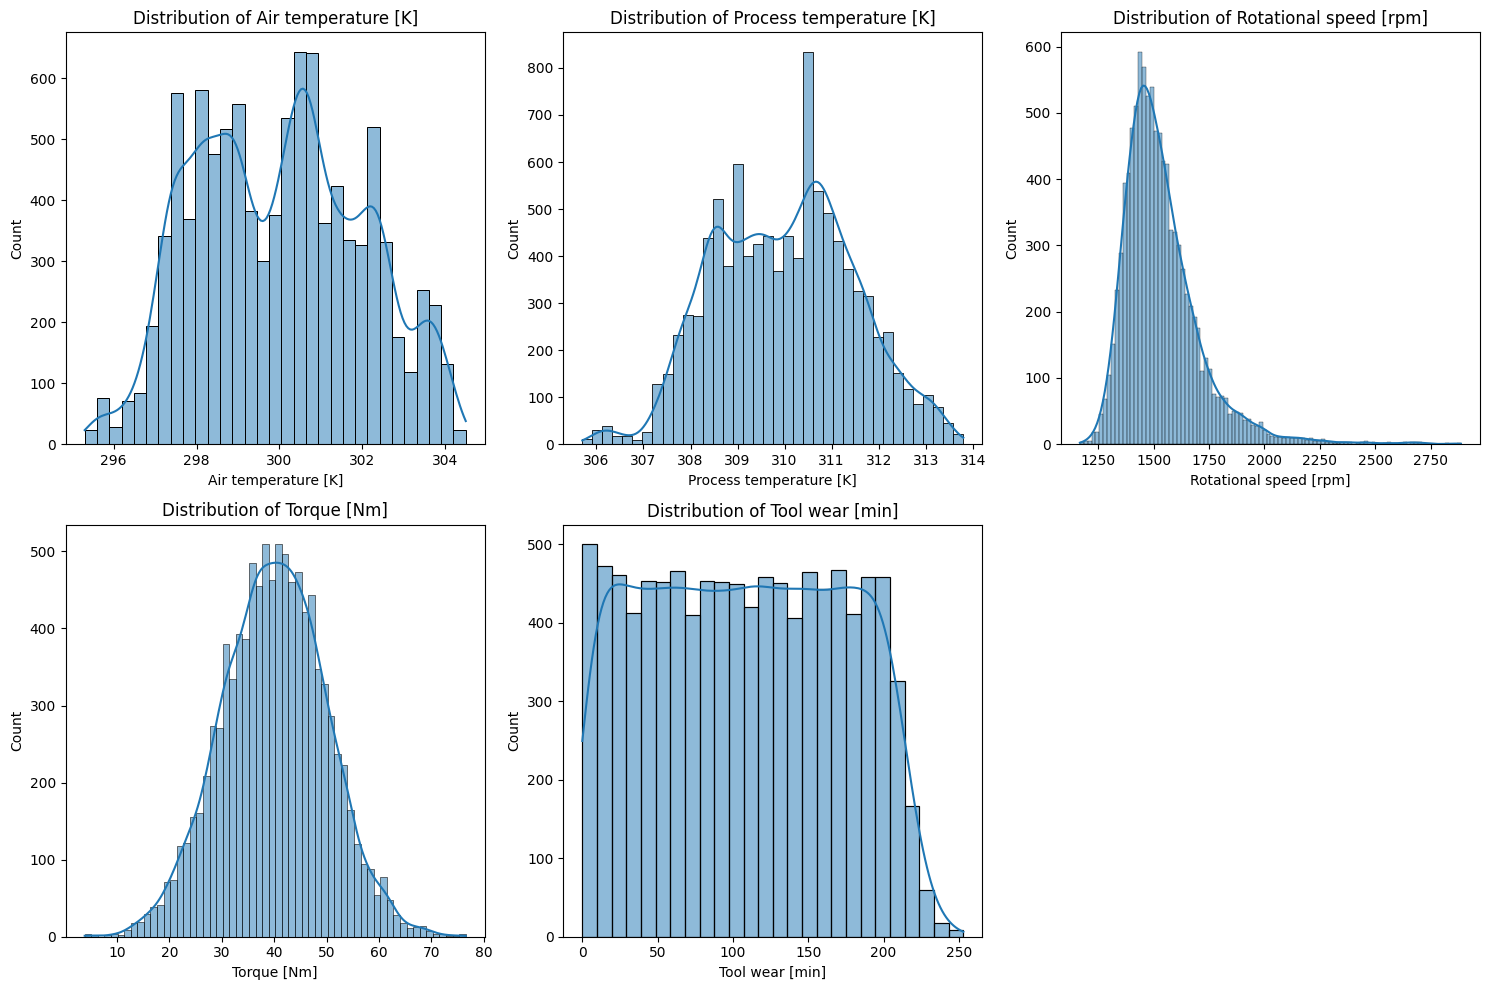

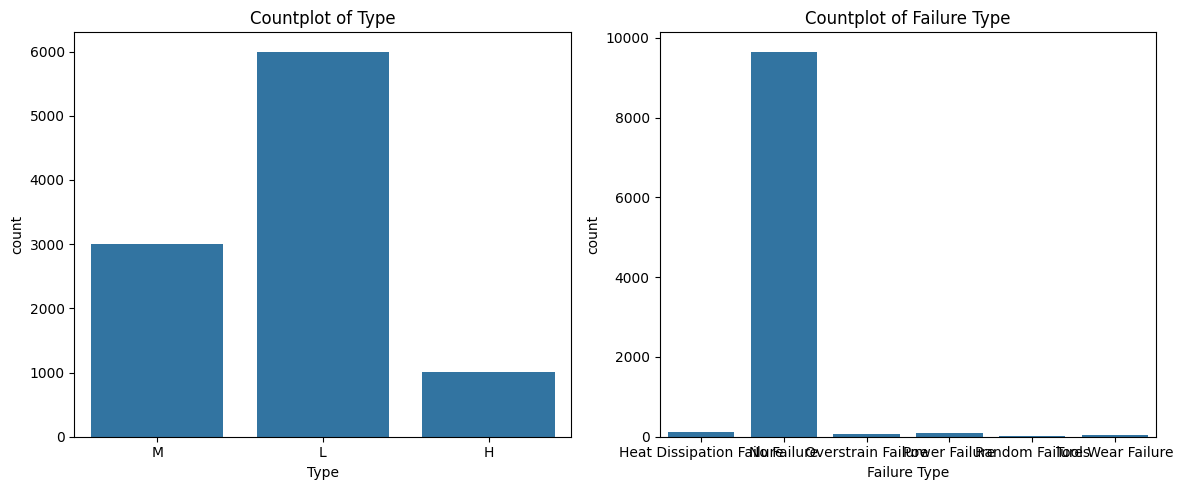

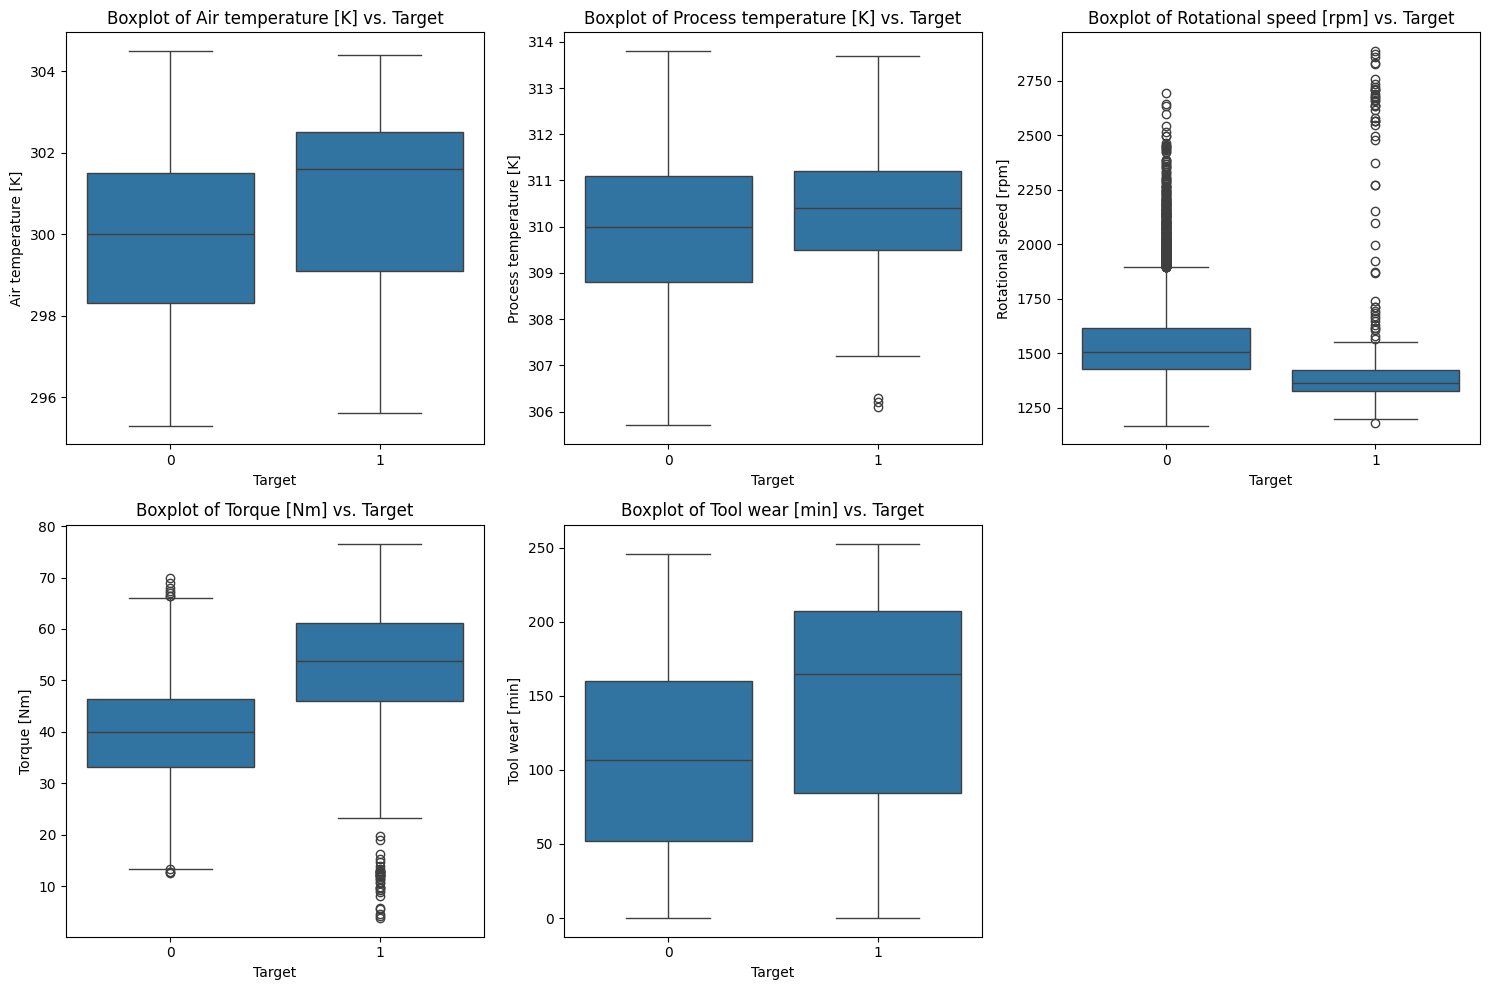

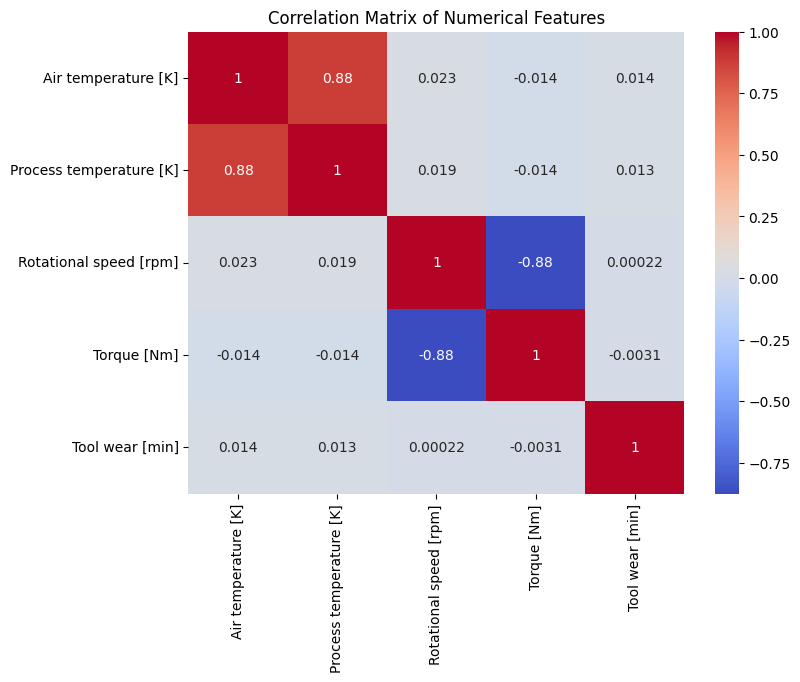

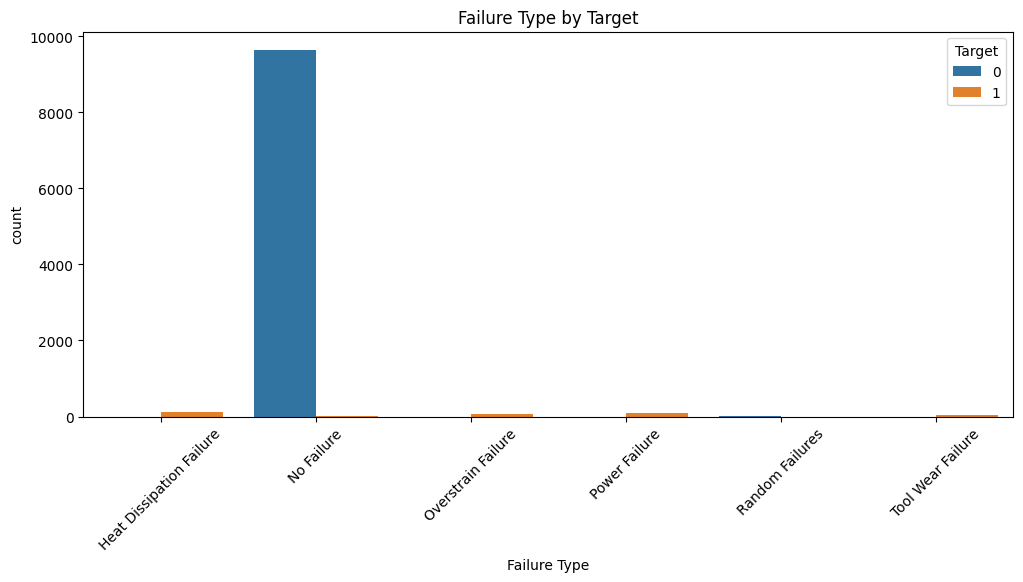

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("data/predictive_maintenance.csv", encoding='utf-8')

data = data.drop(['UDI'], axis=1) 
data = data.drop(['Product ID'], axis=1) 

data['Target'] = data['Target'].astype('category')
data['Failure Type'] = data['Failure Type'].astype('category')

print("Data shape:", data.shape)
print("\nData Info:")
print(data.info())
print("\nDescriptive Statistics:")
print(data.describe()) 
print("\nValue Counts for Target Variable:")
print(data['Target'].value_counts())

numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1) 
    sns.histplot(data[feature], kde=True) 
    plt.title(f'Distribution of {feature}')
plt.tight_layout()  
plt.show()

categorical_features = ['Type', 'Failure Type']

plt.figure(figsize=(12, 5))
for i, feature in enumerate(categorical_features):
    plt.subplot(1, 2, i + 1)
    sns.countplot(data=data, x=feature)
    plt.title(f'Countplot of {feature}')
plt.tight_layout()
plt.show()
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=data, x='Target', y=feature)
    plt.title(f'Boxplot of {feature} vs. Target')
plt.tight_layout()
plt.show()

correlation_matrix = data[numerical_features].corr()  
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm') 
plt.title('Correlation Matrix of Numerical Features')
plt.show()

plt.figure(figsize=(12, 5))
sns.countplot(data=data, x='Failure Type', hue='Target')
plt.title('Failure Type by Target')
plt.xticks(rotation=45)
plt.show()

Shape of X_train after preprocessing: (8000, 8)
Data type of X_train: float64
Unique values in y_train: [0 1]
Shape of X_train before SMOTE: (8000, 8)
Shape of X_train after SMOTE: (15458, 8)

Value Counts for Target Variable after SMOTE:
Target
0    7729
1    7729
Name: count, dtype: int64
Shape of X_train before RandomOverSampler: (8000, 8)
Shape of X_train after RandomOverSampler: (15458, 8)

Value Counts for Target Variable after RandomOverSampler:
Target
0    7729
1    7729
Name: count, dtype: int64


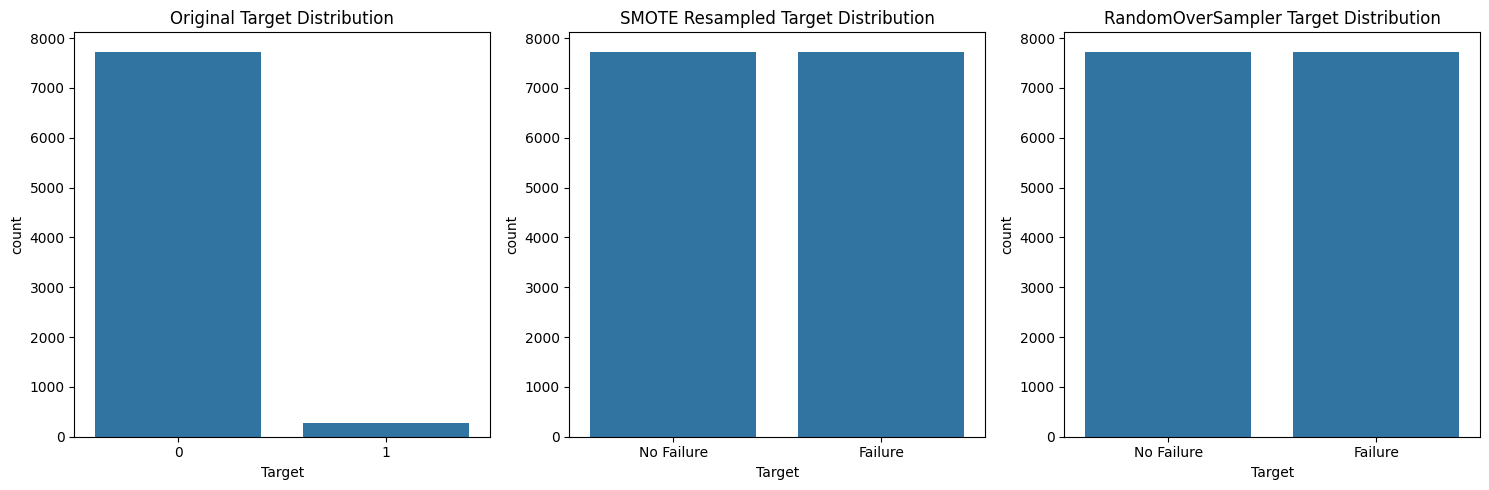

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler

data = pd.read_csv("data/predictive_maintenance.csv", encoding='utf-8')

data = data.drop(['UDI', 'Product ID', 'Failure Type'], axis=1)

numerical_features = ['Air temperature [K]', 'Process temperature [K]',
                      'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Type']
target = 'Target'

X = data.drop(target, axis=1)
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features)
], remainder='passthrough')

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

numerical_features = list(range(5))
categorical_features = list(range(5, X_train.shape[1]))

print("Shape of X_train after preprocessing:", X_train.shape)
print("Data type of X_train:", X_train.dtype) 
print("Unique values in y_train:", np.unique(y_train))

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print("Shape of X_train before SMOTE:", X_train.shape)
print("Shape of X_train after SMOTE:", X_train_smote.shape)
print("\nValue Counts for Target Variable after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

print("Shape of X_train before RandomOverSampler:", X_train.shape)
print("Shape of X_train after RandomOverSampler:", X_train_ros.shape)
print("\nValue Counts for Target Variable after RandomOverSampler:")
print(pd.Series(y_train_ros).value_counts())

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x=y_train)
plt.title("Original Target Distribution")

plt.subplot(1, 3, 2)
sns.countplot(x=y_train_smote)
plt.title("SMOTE Resampled Target Distribution")
plt.xticks(ticks=[0,1], labels=['No Failure', 'Failure'])

plt.subplot(1, 3, 3)
sns.countplot(x=y_train_ros)
plt.title("RandomOverSampler Target Distribution")
plt.xticks(ticks=[0,1], labels=['No Failure', 'Failure'])

plt.tight_layout()
plt.show()


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np

data = pd.read_csv("data/predictive_maintenance.csv", encoding='utf-8')

data = data.drop(['UDI', 'Product ID'], axis=1)

X = data.drop(['Failure Type'], axis=1)
y = data['Failure Type'].astype('category').cat.codes 

categorical_cols = ['Type']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) 
X_encoded = encoder.fit_transform(X[categorical_cols])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_cols])

X_processed = np.hstack((X_scaled, X_encoded))

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DNN(input_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Epoch [1/20], Loss: 0.5644
Epoch [2/20], Loss: 0.1263
Epoch [3/20], Loss: 0.0560
Epoch [4/20], Loss: 0.0370
Epoch [5/20], Loss: 0.0509
Epoch [6/20], Loss: 0.1390
Epoch [7/20], Loss: 0.0242
Epoch [8/20], Loss: 0.0052
Epoch [9/20], Loss: 0.0154
Epoch [10/20], Loss: 0.0063
Epoch [11/20], Loss: 0.0417
Epoch [12/20], Loss: 0.0099
Epoch [13/20], Loss: 0.0514
Epoch [14/20], Loss: 0.0131
Epoch [15/20], Loss: 0.0112
Epoch [16/20], Loss: 0.0055
Epoch [17/20], Loss: 0.0707
Epoch [18/20], Loss: 0.0024
Epoch [19/20], Loss: 0.0037
Epoch [20/20], Loss: 0.0234
Test Accuracy: 99.50%


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd
import numpy as np

data = pd.read_csv("data/predictive_maintenance.csv", encoding='utf-8')

data = data.drop(['UDI', 'Product ID'], axis=1)

X = data.drop(['Failure Type'], axis=1)
y = data['Failure Type'].astype('category').cat.codes 

categorical_cols = ['Type']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_cols])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_cols])

X_processed = np.hstack((X_scaled, X_encoded))

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size, num_classes, lr=0.001, hidden_units=128, optimizer_type="adam", num_epochs=10):
        self.input_size = input_size
        self.num_classes = num_classes
        self.lr = lr
        self.hidden_units = hidden_units
        self.optimizer_type = optimizer_type
        self.num_epochs = num_epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._build_model()

    def _build_model(self):
        self.model = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_units),
            nn.ReLU(),
            nn.BatchNorm1d(self.hidden_units),
            nn.Dropout(0.3),
            nn.Linear(self.hidden_units, self.num_classes)
        ).to(self.device)

        self.criterion = nn.CrossEntropyLoss()
        if self.optimizer_type == "adam":
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        elif self.optimizer_type == "sgd":
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)

    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(self.device)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self._build_model()
        for epoch in range(self.num_epochs):
            self.model.train()
            for X_batch, y_batch in loader:
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
        return predicted.cpu().numpy()

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

param_grid = {
    "lr": [0.01, 0.001, 0.0001],
    "hidden_units": [64, 128, 256],
    "optimizer_type": ["adam", "sgd"],
    "num_epochs": [10, 20]
}

classifier = PyTorchClassifier(input_size=X_train.shape[1], num_classes=len(np.unique(y_train)))
grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring="accuracy", verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Test Accuracy with Best Parameters: {test_accuracy:.2f}%")


Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
36 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Amine\AppData\Local\Temp\ipykernel_14084\2443064921.py", line 71, in fit
ValueError: could not determine the shape of object type 'Series'

  warnings.warn(some_fits_failed_message, FitFailedWarning)
c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores 

Best Parameters: {'hidden_units': 64, 'lr': 0.01, 'num_epochs': 10, 'optimizer_type': 'adam'}
Best Accuracy: nan
Test Accuracy with Best Parameters: 0.99%


Epoch [1/20], Loss: 0.0187, Train Accuracy: 71.22%, Test Accuracy: 98.60%
Epoch [2/20], Loss: 0.0054, Train Accuracy: 95.53%, Test Accuracy: 98.65%
Epoch [3/20], Loss: 0.0026, Train Accuracy: 97.70%, Test Accuracy: 99.30%
Epoch [4/20], Loss: 0.0017, Train Accuracy: 98.30%, Test Accuracy: 99.40%
Epoch [5/20], Loss: 0.0012, Train Accuracy: 98.67%, Test Accuracy: 99.40%
Epoch [6/20], Loss: 0.0010, Train Accuracy: 98.81%, Test Accuracy: 99.50%
Epoch [7/20], Loss: 0.0008, Train Accuracy: 98.89%, Test Accuracy: 99.35%
Epoch [8/20], Loss: 0.0009, Train Accuracy: 98.95%, Test Accuracy: 99.15%
Epoch [9/20], Loss: 0.0008, Train Accuracy: 98.94%, Test Accuracy: 99.40%
Epoch [10/20], Loss: 0.0007, Train Accuracy: 99.00%, Test Accuracy: 99.50%
Epoch [11/20], Loss: 0.0006, Train Accuracy: 99.16%, Test Accuracy: 99.25%
Epoch [12/20], Loss: 0.0006, Train Accuracy: 99.15%, Test Accuracy: 98.85%
Epoch [13/20], Loss: 0.0006, Train Accuracy: 99.08%, Test Accuracy: 99.30%
Epoch [14/20], Loss: 0.0006, Train

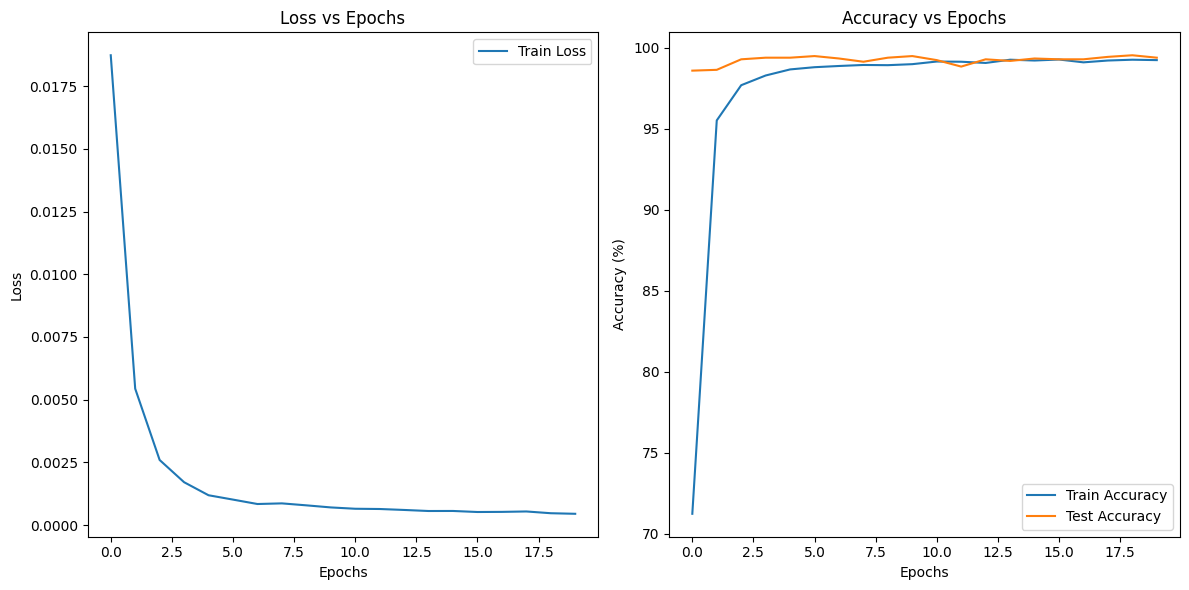

Test Accuracy: 0.99
F1 Score: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        22
           1       1.00      1.00      1.00      1930
           2       0.76      1.00      0.86        16
           3       1.00      0.89      0.94        19
           4       0.00      0.00      0.00         4
           5       0.80      0.44      0.57         9

    accuracy                           0.99      2000
   macro avg       0.76      0.72      0.73      2000
weighted avg       0.99      0.99      0.99      2000



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


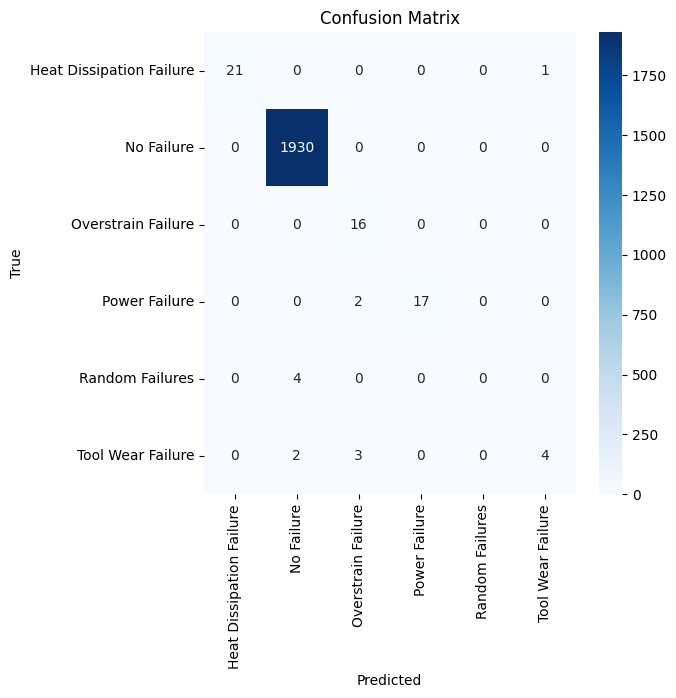

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv("data/predictive_maintenance.csv", encoding='utf-8')

data = data.drop(['UDI', 'Product ID'], axis=1)

X = data.drop(['Failure Type'], axis=1)
y = data['Failure Type']

categorical_cols = ['Type']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_cols])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_cols])

X_processed = np.hstack((X_scaled, X_encoded))

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

X_train = pd.DataFrame(X_train)  
X_test = pd.DataFrame(X_test)    

X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long).to(device)

class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

input_size = X_train.shape[1]  
num_classes = len(np.unique(y_train)) 
model = DNN(input_size, num_classes).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for i in range(0, len(X_train_tensor), 64):
        X_batch = X_train_tensor[i:i+64]
        y_batch = y_train_tensor[i:i+64]

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

    avg_train_loss = running_train_loss / len(X_train_tensor)
    train_accuracy = 100 * correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        total_test += y_test_tensor.size(0)
        correct_test += (predicted == y_test_tensor).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label="Train Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label="Train Accuracy")
plt.plot(range(num_epochs), test_accuracies, label="Test Accuracy")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

y_test_pred = model(X_test_tensor).argmax(dim=1).cpu().numpy()
print(f"Test Accuracy: {accuracy_score(y_test_encoded, y_test_pred):.2f}")
print(f"F1 Score: {f1_score(y_test_encoded, y_test_pred, average='weighted'):.2f}")
print("Classification Report:\n", classification_report(y_test_encoded, y_test_pred))

cm = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: Unde

Training Set Metrics:
Accuracy: 0.9959
Precision: 0.9943
Recall (Sensitivity): 0.9959
F1 Score: 0.9950
Confusion Matrix (Training):
 [[  80    3    4    1    0    2]
 [   0 7721    1    0    0    0]
 [   0    0   61    1    0    0]
 [   1    0    5   70    0    0]
 [   0   14    0    0    0    0]
 [   0    0    1    0    0   35]]

Test Set Metrics:
Accuracy: 0.9940
Precision: 0.9922
Recall (Sensitivity): 0.9940
F1 Score: 0.9927
Confusion Matrix (Test):
 [[  21    0    0    0    0    1]
 [   0 1930    0    0    0    0]
 [   0    0   16    0    0    0]
 [   0    0    2   17    0    0]
 [   0    4    0    0    0    0]
 [   0    2    3    0    0    4]]

Classification Report (Train Set):
               precision    recall  f1-score   support

           0       0.99      0.89      0.94        90
           1       1.00      1.00      1.00      7722
           2       0.85      0.98      0.91        62
           3       0.97      0.92      0.95        76
           4       0.00      0.00  

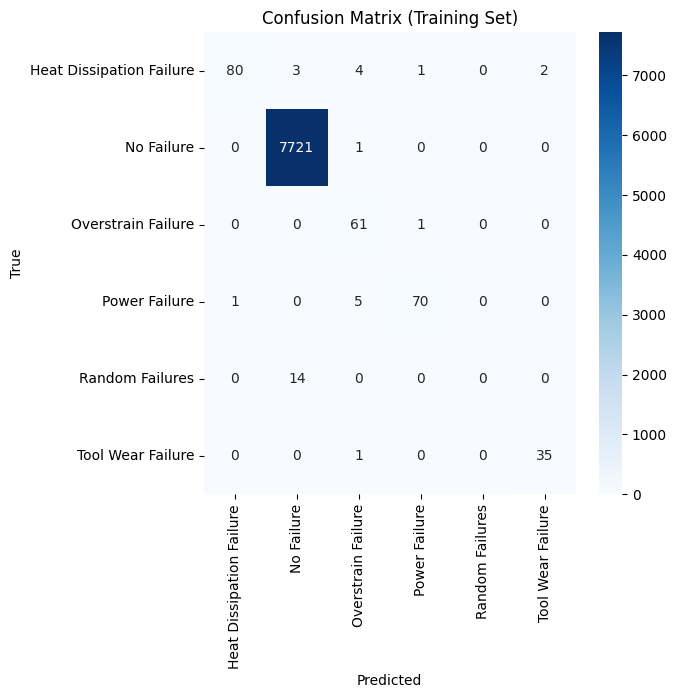

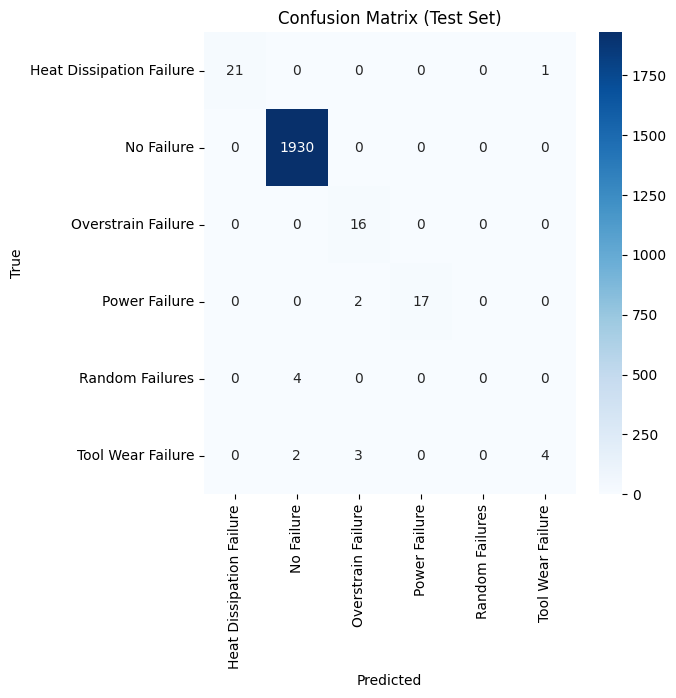

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
train_outputs = model(X_train_tensor)
_, train_predicted = torch.max(train_outputs.data, 1)

train_pred = train_predicted.cpu().numpy()
train_true = y_train_tensor.cpu().numpy()

train_accuracy = accuracy_score(train_true, train_pred)
train_precision = precision_score(train_true, train_pred, average='weighted')
train_recall = recall_score(train_true, train_pred, average='weighted')
train_f1 = f1_score(train_true, train_pred, average='weighted')

print(f"Training Set Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall (Sensitivity): {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("Confusion Matrix (Training):\n", confusion_matrix(train_true, train_pred))

test_outputs = model(X_test_tensor)
_, test_predicted = torch.max(test_outputs.data, 1)

test_pred = test_predicted.cpu().numpy()
test_true = y_test_tensor.cpu().numpy()

test_accuracy = accuracy_score(test_true, test_pred)
test_precision = precision_score(test_true, test_pred, average='weighted')
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')

print(f"\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall (Sensitivity): {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print("Confusion Matrix (Test):\n", confusion_matrix(test_true, test_pred))

print("\nClassification Report (Train Set):\n", classification_report(train_true, train_pred))
print("\nClassification Report (Test Set):\n", classification_report(test_true, test_pred))

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(train_true, train_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (Training Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(test_true, test_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [41]:
import torch.nn as nn
import torch.optim as optim

class RegularizedModel(nn.Module):
    def __init__(self):
        super(RegularizedModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.bn1 = nn.BatchNorm1d(64)  
        self.dropout1 = nn.Dropout(0.5)  
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, len(label_encoder.classes_))  

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

regularized_model = RegularizedModel().to(device)

optimizer = optim.Adam(regularized_model.parameters(), lr=0.001, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()

def train_regularized_model(model, optimizer, criterion, train_loader, test_loader, n_epochs=20):
    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        epoch_test_accuracy = 100 * correct_test / total_test
        test_losses.append(test_loss / len(test_loader))

        print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {running_loss / len(train_loader):.4f} - Train Accuracy: {epoch_train_accuracy:.2f}% - Test Loss: {test_loss / len(test_loader):.4f} - Test Accuracy: {epoch_test_accuracy:.2f}%')

    return train_losses, test_losses, epoch_train_accuracy, epoch_test_accuracy

train_losses, test_losses, train_accuracy, test_accuracy = train_regularized_model(regularized_model, optimizer, criterion, train_loader, test_loader, n_epochs=20)

train_pred = train_predicted.cpu().numpy()
train_true = y_train_tensor.cpu().numpy()
test_pred = test_predicted.cpu().numpy()
test_true = y_test_tensor.cpu().numpy()

train_accuracy = accuracy_score(train_true, train_pred)
train_precision = precision_score(train_true, train_pred, average='weighted')
train_recall = recall_score(train_true, train_pred, average='weighted')
train_f1 = f1_score(train_true, train_pred, average='weighted')

test_accuracy = accuracy_score(test_true, test_pred)
test_precision = precision_score(test_true, test_pred, average='weighted')
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')

print(f"Regularized Model - Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/20 - Train Loss: 1.2314 - Train Accuracy: 62.61% - Test Loss: 0.5706 - Test Accuracy: 97.30%
Epoch 2/20 - Train Loss: 0.3123 - Train Accuracy: 96.91% - Test Loss: 0.1618 - Test Accuracy: 97.90%
Epoch 3/20 - Train Loss: 0.1650 - Train Accuracy: 96.94% - Test Loss: 0.0967 - Test Accuracy: 97.65%
Epoch 4/20 - Train Loss: 0.1203 - Train Accuracy: 96.99% - Test Loss: 0.0786 - Test Accuracy: 98.20%
Epoch 5/20 - Train Loss: 0.1002 - Train Accuracy: 97.10% - Test Loss: 0.0712 - Test Accuracy: 98.00%
Epoch 6/20 - Train Loss: 0.0927 - Train Accuracy: 97.15% - Test Loss: 0.0677 - Test Accuracy: 97.85%
Epoch 7/20 - Train Loss: 0.0863 - Train Accuracy: 97.24% - Test Loss: 0.0660 - Test Accuracy: 97.95%
Epoch 8/20 - Train Loss: 0.0824 - Train Accuracy: 97.21% - Test Loss: 0.0642 - Test Accuracy: 97.80%
Epoch 9/20 - Train Loss: 0.0765 - Train Accuracy: 97.24% - Test Loss: 0.0625 - Test Accuracy: 98.15%
Epoch 10/20 - Train Loss: 0.0772 - Train Accuracy: 97.11% - Test Loss: 0.0615 - Test Accura

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
